# Retinal Blood Vessels Segmentation

## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [ ]:
!pip install gdown

In [ ]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
! unzip DRIVE

Downloading...
From (original): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
From (redirected): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte&confirm=t&uuid=4a39cb32-a5d4-415e-a5cd-7d87fb3703b6
To: /content/DRIVE.zip
100% 29.8M/29.8M [00:00<00:00, 74.4MB/s]
Archive:  DRIVE.zip
   creating: DRIVE/Test/
   creating: DRIVE/Test/1st_manual/
 extracting: DRIVE/Test/1st_manual/01_manual1.gif  
 extracting: DRIVE/Test/1st_manual/02_manual1.gif  
 extracting: DRIVE/Test/1st_manual/03_manual1.gif  
 extracting: DRIVE/Test/1st_manual/04_manual1.gif  
 extracting: DRIVE/Test/1st_manual/05_manual1.gif  
 extracting: DRIVE/Test/1st_manual/06_manual1.gif  
 extracting: DRIVE/Test/1st_manual/07_manual1.gif  
 extracting: DRIVE/Test/1st_manual/08_manual1.gif  
 extracting: DRIVE/Test/1st_manual/09_manual1.gif  
 extracting: DRIVE/Test/1st_manual/10_manual1.gif  
 extracting: DRIVE/Test/1st_manual/11_manual1.gif  
 extracting: DRIVE/Test/1st_manual/12_manual1.gif 

In [ ]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [ ]:
def plot_images(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images), cmap='gray'
    )
    plt.axis('off')
    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

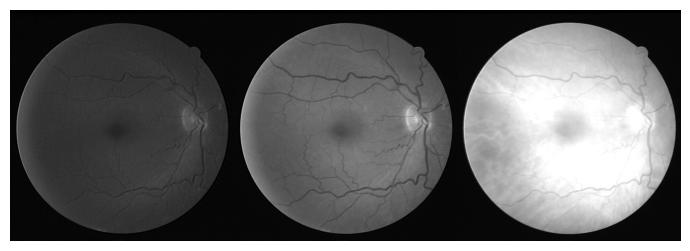

In [ ]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]])

We should select green channel becuase it show a good contrast between of vessels and background.

## Pre-Process

In [ ]:
from skimage.morphology import disk, opening, closing, erosion, dilation
import skimage.morphology as morphology

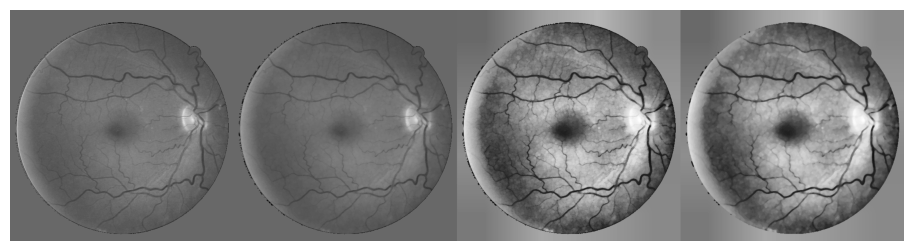

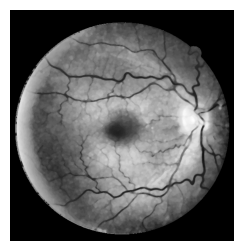

In [ ]:
def PreProcess (image: np.ndarray, mask: np.ndarray,plot_image: bool) :
  """
      Args:
          - image (np.ndarray): A 2D  array, shape (height, width).
          - mask (np.ndarray): A binary mask array, shape (height, width).

      Returns:
          - Processed Image (np.ndarray): A 2D array of the same shape as image.

      Steps:
          - Mask Adjustment:
          - Morphological Opening
          - Contrast Enhancement
          - Smoothing


  """

  #first convert mask to binary mask
  index = np.where(mask > 0)
  mask[index] = 1

  #replace zero masks with mean of the masked image
  masked_image = image * mask
  mean = np.mean(masked_image[masked_image > 0])
  index = masked_image == 0
  image[index] = mean

  SE = disk(2)
  #now perform steps mentioned in document :
  # https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
  # https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
  # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9


  # Morphological opening (erosion followed by dilation)
  opening = morphology.opening(image, SE)

  # Contrast Limited Adaptive Histogram Equalization (CLAHE)
  clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4, 4))
  clh = clahe.apply(opening.astype(np.uint8))

  # Median smoothing
  median = cv2.medianBlur(clh, 5)

  if plot_image:
    plot_images([image,opening,clh,median])
  return np.multiply(median, mask)

test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed])


## Feature Extraction

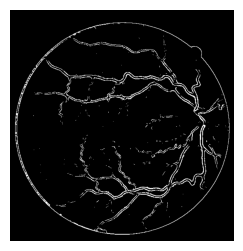

In [ ]:
def Roberts_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """

    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.
    image = image.astype('float64')/255.0
    roberts_cross_v = np.array([[1, 0], [0, -1]])
    roberts_cross_h = np.array([[0, 1], [-1, 0]])

    vertical = cv2.filter2D(image, -1, roberts_cross_v)
    horizontal = cv2.filter2D(image, -1, roberts_cross_h)
    edged_img_sqrt = np.sqrt(np.square(vertical) + np.square(horizontal))
    edged_img = np.uint8(255 * edged_img_sqrt / np.max(edged_img_sqrt))
    _, edged_img_thersh = cv2.threshold(edged_img, 25, 255, cv2.THRESH_BINARY)

    return edged_img_thersh


test_edged_img=Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

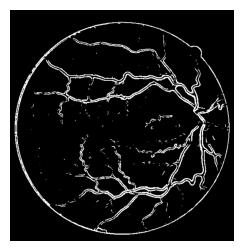

In [ ]:
def Prewitt_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    kernelx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernely = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    image = image.astype('float64')/255.0
    img_prewittx = cv2.filter2D(image, -1, kernelx)
    img_prewitty = cv2.filter2D(image, -1, kernely)
    edged_img_sqrt = np.sqrt(np.square(img_prewittx) + np.square(img_prewitty))
    edged_img = np.uint8(255 * edged_img_sqrt / np.max(edged_img_sqrt))
    _, edged_img = cv2.threshold(edged_img, 30, 255, cv2.THRESH_BINARY)

    return edged_img

test_edged_img=Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

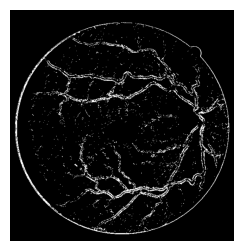

In [ ]:
from scipy.ndimage import gaussian_laplace
import builtins
from skimage.filters import laplace

def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    mask = np.ones_like(image)
    mask[image == 0] = 0

    gauss = cv2.GaussianBlur(image, (0,0), 0.05)
    LoG = laplace(gauss)

    p = 1
    LoG = np.pad(LoG, ((0, p), (0, p)))
    diff_x = LoG[:-p, :-p] - LoG[:-p, p:]
    diff_y = LoG[:-p, :-p] - LoG[p:, :-p]

    edges = np.sqrt(np.square(diff_x) + np.square(diff_y))
    edges = edges / np.max(edges)

    edges = edges * mask
    edges_normalized = (edges - np.min(edges)) / (np.max(edges) - np.min(edges))
    edges = np.float64(edges_normalized)

    thresh = 0.045
    edges[edges > thresh] = 255
    edges[edges < thresh] = 0

    return edges

test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

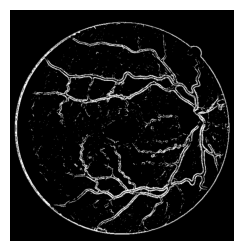

In [ ]:
from scipy.ndimage import convolve

def Edge_Algorithm_features(image):
    """
      Extract edge features from a grayscale image using Roberts, Prewitt and LOG edge detection algorithms.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width)

      Returns:
          np.ndarray: A binary image of the same shape as the input image.
    """

    def Sobel_Edge_Detection(image):
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edge_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        edge_sobel = (edge_sobel > 0.1 * edge_sobel.max()).astype(np.uint8) * 255
        return edge_sobel


    R = Roberts_Edge_Detection(image)
    P = Prewitt_Edge_Detection(image)
    S = Sobel_Edge_Detection(image)
    C = cv2.Canny(image, 100, 200)
    L = LOG_Edge_Detection(image)

    return R + P + S + C + L

test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img])

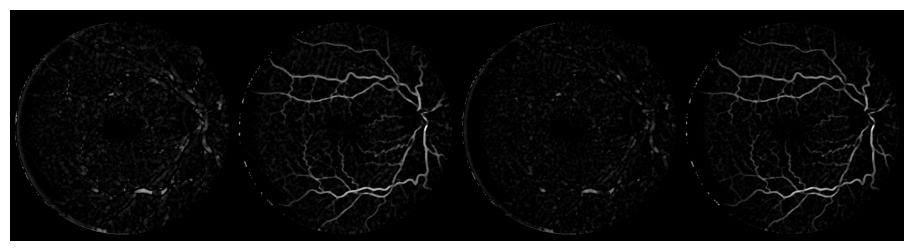

In [ ]:
def Morphological_features(image):
    """
      Extract morphological features from a grayscale image using
      top-hat and black-hat morphological transformations.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).

      Returns:
          tuple: A tuple containing four elements:
              - tophat_img (np.ndarray): The top-hat transformed image, highlighting
                bright features on a dark background.
              - bothat_img (np.ndarray): The black-hat transformed image, emphasizing
                dark features on a bright background.
              - tophat_img2 (np.ndarray): The second top-hat transformed image with
                a different structuring element orientation.
              - bothat_img2 (np.ndarray): The second black-hat transformed image with
                a different structuring element orientation.

    """
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))

    tophat_img = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel1)

    bothat_img = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel1)

    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

    tophat_img2 = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel2)

    bothat_img2 = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel2)

    return tophat_img, bothat_img, tophat_img2, bothat_img2

test_morph_image=Morphological_features(test_img_preprocessed)
plot_images(test_morph_image)


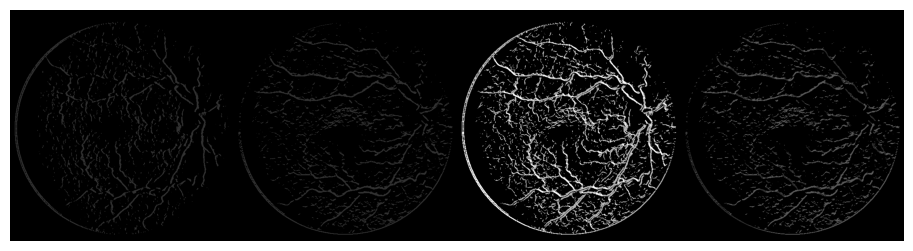

In [ ]:
def Gradient_Based_features (image) :
    """
        Calculate gradient-based features from a grayscale image using
        convolution with Sobel-like kernels.

        Args:
            image (np.ndarray): A 2D grayscale image array of shape (height, width).


        Returns:
            tuple: A tuple containing four elements:
                - Gx (np.ndarray): The gradient of the image in the x-direction.
                - Gy (np.ndarray): The gradient of the image in the y-direction.
                - M (np.ndarray): The magnitude of the gradient.
                - Theta (np.ndarray): The angle of the gradient direction.
    """

    dx_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    dy_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Gx = cv2.filter2D(image, cv2.CV_64F, dx_kernel)
    Gy = cv2.filter2D(image, cv2.CV_64F, dy_kernel)

    _, Gx = cv2.threshold(Gx, 30, 50, cv2.THRESH_BINARY)
    _, Gy = cv2.threshold(Gy, 30, 50, cv2.THRESH_BINARY)

    M = np.sqrt(Gx**2 + Gy**2)
    M = (M / M.max() * 255).astype(np.uint8)

    Theta = np.arctan2(Gy, Gx) * (180 / np.pi)
    Theta = np.mod(Theta + 360, 360)

    return Gx, Gy, M, Theta

test_gradient_image=Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image)


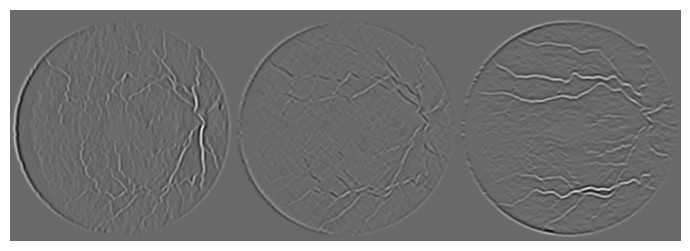

In [ ]:
def Hessian_features(image) :
  """
    Calculate Hessian matrix components for a given grayscale image
    to capture second-order derivative information for edge detection.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).

    Returns:
        tuple: A tuple containing three elements:
            - Gxx (np.ndarray): The second derivative of the image with respect
              to the x-direction.
            - Gxy (np.ndarray): The mixed second derivative of the image with respect
              to both x and y directions.
            - Gyy (np.ndarray): The second derivative of the image with respect
              to the y-direction.
  """
  image = cv2.GaussianBlur(image, (7,7), 3.4)
  Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
  Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

  Gxx = cv2.Sobel(Ix, cv2.CV_64F, 1, 0, ksize=9)
  Gxy = cv2.Sobel(Ix, cv2.CV_64F, 0, 1, ksize=9)
  Gyy = cv2.Sobel(Iy, cv2.CV_64F, 0, 1, ksize=9)

  Gxx = cv2.GaussianBlur(Gxx, (5,5), 1)
  Gxy = cv2.GaussianBlur(Gxy, (5,5), 1)
  Gyy = cv2.GaussianBlur(Gyy, (5,5), 1)

  return Gxx, Gxy, Gyy

test_hessian_image=Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image)

In [ ]:
def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    padded_img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, value=image.mean())
    output = np.zeros((image.shape[0], image.shape[1], 8))

    X, Y = index

    for idx in range(len(index[0])):
        i = X[idx] + k
        j = Y[idx] + k

        neighborhood = padded_img[i-k:i+k+1, j-k:j+k+1].flatten()

        mean_val = np.mean(neighborhood)
        min_val = np.min(neighborhood)
        max_val = np.max(neighborhood)
        skew_val = skew(neighborhood)
        kurt_val = kurtosis(neighborhood)
        std_val = np.std(neighborhood)
        mad_val = np.mean(np.abs(neighborhood - mean_val))
        sqrt_val = np.sqrt(np.sum(neighborhood ** 2))

        output[X[idx], Y[idx], 0] = mean_val
        output[X[idx], Y[idx], 1] = min_val
        output[X[idx], Y[idx], 2] = max_val
        output[X[idx], Y[idx], 3] = skew_val
        output[X[idx], Y[idx], 4] = kurt_val
        output[X[idx], Y[idx], 5] = std_val
        output[X[idx], Y[idx], 6] = mad_val
        output[X[idx], Y[idx], 7] = sqrt_val

    return output

index = np.where(test_mask != 0)
test_statistic_features=Statistical_features(test_img_preprocessed,index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features=np.stack((mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index]), axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
df

,0,1,2,3,4,5,6,7
0,35.598639,0.0,95.0,0.195730,-1.775694,36.977653,35.517917,182.797702
1,35.181406,0.0,95.0,0.202206,-1.751667,36.465605,34.942077,178.793177
2,34.759637,0.0,95.0,0.206806,-1.728682,35.934386,34.365537,173.657709
3,34.351474,0.0,95.0,0.208129,-1.709007,35.395418,33.806212,169.313319
4,33.995465,0.0,95.0,0.204797,-1.695640,34.883414,33.301680,164.790776
...,...,...,...,...,...,...,...,...
227681,37.142857,0.0,152.0,0.662682,-0.133463,39.940091,36.384840,147.132593
227682,36.487528,0.0,152.0,0.672555,-0.102668,39.409478,35.908361,144.806768
227683,35.852608,0.0,151.0,0.678026,-0.077852,38.855959,35.446116,143.251527
227684,35.208617,0.0,151.0,0.682524,-0.050537,38.274128,34.969102,143.125819


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_image_path = 'DRIVE/Training/images/'
train_mask_path = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'
def extract_features(image_path, mask_path, label_path):
    images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
    images.sort()
    masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
    masks.sort()
    labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
    labels.sort()

    data = pd.DataFrame()
    total_images = len(images)
    for i in tqdm(range(total_images)):
        image = cv2.imread(join(image_path, images[i]))
        mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
        label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
        label[np.where(label == 255)] = 1
        index = np.where(mask != 0)
        image = PreProcess(image[:, :, 1], mask, False)

        ################# Feature extraction #################
        edges = Edge_Algorithm_features(image)
        tophat, bothat, tophat2, bothat2 = Morphological_features(image)
        mean, min_val, max_val, skew_val, kurt_val, std_val, mad_val, sqrt_val = np.transpose(Statistical_features(image, index), (2, 0, 1))[:]
        Gx, Gy, M, Theta = Gradient_Based_features(image)
        Gxx, Gxy, Gyy = Hessian_features(image)
        features = np.stack((edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
                             mean[index], min_val[index], max_val[index], skew_val[index], kurt_val[index], std_val[index], mad_val[index], sqrt_val[index],
                             M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)

        df = pd.DataFrame(features)
        data = pd.concat([data, df], ignore_index=True)

        print(f"Processed {i+1}/{total_images} images ({(i+1)/total_images*100:.2f}%)")

    return data


In [ ]:
df_train = extract_features(train_image_path, train_mask_path, train_label_path)

  5%|▌         | 1/20 [06:40<2:06:47, 400.41s/it]

Processed 1/20 images (5.00%)


 10%|█         | 2/20 [13:11<1:58:29, 394.98s/it]

Processed 2/20 images (10.00%)


 15%|█▌        | 3/20 [19:42<1:51:26, 393.30s/it]

Processed 3/20 images (15.00%)


 20%|██        | 4/20 [26:16<1:44:51, 393.23s/it]

Processed 4/20 images (20.00%)


 25%|██▌       | 5/20 [32:51<1:38:28, 393.87s/it]

Processed 5/20 images (25.00%)


 30%|███       | 6/20 [39:47<1:33:43, 401.70s/it]

Processed 6/20 images (30.00%)


 35%|███▌      | 7/20 [46:21<1:26:25, 398.90s/it]

Processed 7/20 images (35.00%)


 40%|████      | 8/20 [52:48<1:19:01, 395.10s/it]

Processed 8/20 images (40.00%)


 45%|████▌     | 9/20 [59:14<1:11:56, 392.42s/it]

Processed 9/20 images (45.00%)


 50%|█████     | 10/20 [1:05:47<1:05:27, 392.72s/it]

Processed 10/20 images (50.00%)


 55%|█████▌    | 11/20 [1:12:19<58:51, 392.37s/it]  

Processed 11/20 images (55.00%)


 60%|██████    | 12/20 [1:18:46<52:05, 390.65s/it]

Processed 12/20 images (60.00%)


 65%|██████▌   | 13/20 [1:25:17<45:36, 390.98s/it]

Processed 13/20 images (65.00%)


 70%|███████   | 14/20 [1:31:53<39:14, 392.34s/it]

Processed 14/20 images (70.00%)


 75%|███████▌  | 15/20 [1:38:31<32:49, 393.95s/it]

Processed 15/20 images (75.00%)


 80%|████████  | 16/20 [1:45:05<26:16, 394.16s/it]

Processed 16/20 images (80.00%)


 85%|████████▌ | 17/20 [1:51:37<19:40, 393.34s/it]

Processed 17/20 images (85.00%)


 90%|█████████ | 18/20 [1:58:14<13:09, 394.58s/it]

Processed 18/20 images (90.00%)


 95%|█████████▌| 19/20 [2:04:52<06:35, 395.53s/it]

Processed 19/20 images (95.00%)


100%|██████████| 20/20 [2:11:29<00:00, 394.47s/it]

Processed 20/20 images (100.00%)


In [ ]:
df_train.to_csv("train.csv")

In [ ]:
import os

dataset_folder = '/content/drive/My Drive/IABI_hw1_dataset'
os.makedirs(dataset_folder, exist_ok=True)

In [ ]:
import shutil

shutil.move("train.csv", dataset_folder)

'/content/drive/My Drive/IABI_hw1_dataset/train.csv'

In [ ]:
df_test = extract_features(test_image_path, test_mask_path, test_label_path)

  5%|▌         | 1/20 [06:47<2:09:06, 407.69s/it]

Processed 1/20 images (5.00%)


 10%|█         | 2/20 [13:15<1:58:51, 396.17s/it]

Processed 2/20 images (10.00%)


 15%|█▌        | 3/20 [19:49<1:51:52, 394.86s/it]

Processed 3/20 images (15.00%)


 20%|██        | 4/20 [26:22<1:45:11, 394.44s/it]

Processed 4/20 images (20.00%)


 25%|██▌       | 5/20 [32:56<1:38:31, 394.12s/it]

Processed 5/20 images (25.00%)


 30%|███       | 6/20 [39:26<1:31:38, 392.76s/it]

Processed 6/20 images (30.00%)


 35%|███▌      | 7/20 [46:03<1:25:21, 394.00s/it]

Processed 7/20 images (35.00%)


 40%|████      | 8/20 [52:33<1:18:34, 392.91s/it]

Processed 8/20 images (40.00%)


 45%|████▌     | 9/20 [59:07<1:12:05, 393.23s/it]

Processed 9/20 images (45.00%)


 50%|█████     | 10/20 [1:05:38<1:05:24, 392.45s/it]

Processed 10/20 images (50.00%)


 55%|█████▌    | 11/20 [1:12:12<58:55, 392.88s/it]  

Processed 11/20 images (55.00%)


 60%|██████    | 12/20 [1:18:47<52:29, 393.73s/it]

Processed 12/20 images (60.00%)


 65%|██████▌   | 13/20 [1:25:20<45:53, 393.42s/it]

Processed 13/20 images (65.00%)


 70%|███████   | 14/20 [1:31:54<39:20, 393.43s/it]

Processed 14/20 images (70.00%)


 75%|███████▌  | 15/20 [1:38:24<32:42, 392.46s/it]

Processed 15/20 images (75.00%)


 80%|████████  | 16/20 [1:44:57<26:10, 392.55s/it]

Processed 16/20 images (80.00%)


 85%|████████▌ | 17/20 [1:51:30<19:38, 392.77s/it]

Processed 17/20 images (85.00%)


 90%|█████████ | 18/20 [1:58:12<13:10, 395.47s/it]

Processed 18/20 images (90.00%)


 95%|█████████▌| 19/20 [2:04:47<06:35, 395.53s/it]

Processed 19/20 images (95.00%)


100%|██████████| 20/20 [2:11:22<00:00, 394.12s/it]

Processed 20/20 images (100.00%)


In [ ]:
df_test.to_csv("test.csv")

In [ ]:
shutil.move("test.csv", dataset_folder)

'/content/drive/My Drive/IABI_hw1_dataset/test.csv'

## Training Phase

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/IABI_hw1_dataset/train.csv")
df_test=pd.read_csv("/content/drive/MyDrive/IABI_hw1_dataset/test.csv")

In [ ]:
df_train.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,507.0,8.0,0.0,50.0,0.0,4.0,0.0,68.197279,0.0,...,-1.986067,68.161204,68.042637,132.155212,180.0,0.0,-6.095151e+05,-77284.493982,-9.501944e+03,0.0
1,1,507.0,8.0,0.0,0.0,0.0,4.0,0.0,68.306122,0.0,...,-1.986544,67.956930,67.841455,129.903811,0.0,0.0,-1.928407e+06,-77594.356023,-1.194667e+06,0.0
2,2,507.0,8.0,0.0,0.0,0.0,4.0,0.0,68.492063,0.0,...,-1.986771,67.830023,67.715509,127.047235,0.0,0.0,-2.886582e+06,-145701.761697,-2.167326e+06,0.0
3,3,507.0,9.0,0.0,0.0,0.0,9.0,0.0,68.721088,0.0,...,-1.986640,67.746839,67.630278,124.715677,0.0,0.0,-3.136029e+06,-277723.815572,-2.860030e+06,0.0
4,4,508.0,9.0,0.0,0.0,0.0,9.0,0.0,69.004535,0.0,...,-1.985437,67.723862,67.596279,121.478393,0.0,0.0,-2.585853e+06,-439919.806675,-3.274092e+06,0.0


In [ ]:
df_train.shape

(4541006, 22)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [ ]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21])
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()


X_test = sc.fit_transform(df_test.iloc[:, 1:21])
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.

In [ ]:
class MyDataset(Dataset):

  def __init__(self,X, Y):

    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(Y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

class Classifier(nn.Module):
   def __init__(self):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(20, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc4 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,1)
   def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc4(x))
      return torch.sigmoid(self.fc3(x))

class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
      super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output,min=1e-8,max=1-1e-8)

        if weights is not None:
            assert len(weights) == 2
            
            #implement weighted cross entropy loss
            loss = (
                weights[1] * target * torch.log(output) +
                weights[0] * (1 - target) * torch.log(1 - output)
            )
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [ ]:
N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [ ]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):

        epoch_loss = 0
        correct=0
        total=0
        for data, target in train_dataloader:

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1, 1.2])
            loss.backward()
            optimizer.step()

            predicted = output >= 0.4
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()

        accu=100.0*correct/total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)

        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch+1, train_loss, accu))

    return model, train_losses, train_accuracies


In [ ]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

  5%|▌         | 1/20 [01:41<32:06, 101.42s/it]

Epoch: 1  Train Loss: 0.2168  Accuracy: 92.412


 10%|█         | 2/20 [03:21<30:06, 100.37s/it]

Epoch: 2  Train Loss: 0.2044  Accuracy: 92.908


 15%|█▌        | 3/20 [04:57<27:59, 98.79s/it] 

Epoch: 3  Train Loss: 0.2007  Accuracy: 93.066


 20%|██        | 4/20 [06:36<26:16, 98.52s/it]

Epoch: 4  Train Loss: 0.1988  Accuracy: 93.140


 25%|██▌       | 5/20 [08:13<24:29, 97.99s/it]

Epoch: 5  Train Loss: 0.1976  Accuracy: 93.183


 30%|███       | 6/20 [09:51<22:51, 97.99s/it]

Epoch: 6  Train Loss: 0.1967  Accuracy: 93.214


 35%|███▌      | 7/20 [11:27<21:08, 97.55s/it]

Epoch: 7  Train Loss: 0.1961  Accuracy: 93.234


 40%|████      | 8/20 [13:06<19:34, 97.85s/it]

Epoch: 8  Train Loss: 0.1956  Accuracy: 93.248


 45%|████▌     | 9/20 [14:42<17:52, 97.47s/it]

Epoch: 9  Train Loss: 0.1951  Accuracy: 93.256


 50%|█████     | 10/20 [16:20<16:16, 97.63s/it]

Epoch: 10  Train Loss: 0.1948  Accuracy: 93.261


 55%|█████▌    | 11/20 [17:57<14:37, 97.46s/it]

Epoch: 11  Train Loss: 0.1944  Accuracy: 93.267


 60%|██████    | 12/20 [19:36<13:01, 97.65s/it]

Epoch: 12  Train Loss: 0.1941  Accuracy: 93.274


 65%|██████▌   | 13/20 [21:12<11:20, 97.29s/it]

Epoch: 13  Train Loss: 0.1938  Accuracy: 93.284


 70%|███████   | 14/20 [22:50<09:44, 97.40s/it]

Epoch: 14  Train Loss: 0.1936  Accuracy: 93.293


 75%|███████▌  | 15/20 [24:28<08:08, 97.67s/it]

Epoch: 15  Train Loss: 0.1934  Accuracy: 93.299


 80%|████████  | 16/20 [26:04<06:29, 97.29s/it]

Epoch: 16  Train Loss: 0.1932  Accuracy: 93.304


 85%|████████▌ | 17/20 [27:42<04:51, 97.29s/it]

Epoch: 17  Train Loss: 0.1930  Accuracy: 93.309


 90%|█████████ | 18/20 [29:19<03:14, 97.18s/it]

Epoch: 18  Train Loss: 0.1928  Accuracy: 93.315


 95%|█████████▌| 19/20 [30:56<01:37, 97.23s/it]

Epoch: 19  Train Loss: 0.1927  Accuracy: 93.320


100%|██████████| 20/20 [32:32<00:00, 97.63s/it]

Epoch: 20  Train Loss: 0.1926  Accuracy: 93.323


--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [ ]:
def evaluation(image, label, mask) :

  TP = TN =  FP = FN = 0
  row, col = image.shape
  for i in range(row):
    for j in range(col):

     # if mask[i, j] != 0:
        p = image[i, j]
        l = label[i, j]
        if p != 0 and l != 0:
          TP +=1
        elif p != 0 and l == 0 :
          FP +=1
        elif p == 0 and l == 0 :
          TN +=1
        elif p == 0 and l != 0 :
          FN +=1

  Sn = TP/(TP + FN)
  Sp = TN/(TN + FP)
  Acc = (TP + TN)/(TP + TN + FP + FN)

  return Sn, Sp, Acc

In [ ]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
! unzip DRIVE

Downloading...
From (original): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
From (redirected): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte&confirm=t&uuid=7d411d68-86b0-48bb-98a6-79e95679a90f
To: /content/DRIVE.zip
100% 29.8M/29.8M [00:00<00:00, 203MB/s]
Archive:  DRIVE.zip
   creating: DRIVE/Test/
   creating: DRIVE/Test/1st_manual/
 extracting: DRIVE/Test/1st_manual/01_manual1.gif  
 extracting: DRIVE/Test/1st_manual/02_manual1.gif  
 extracting: DRIVE/Test/1st_manual/03_manual1.gif  
 extracting: DRIVE/Test/1st_manual/04_manual1.gif  
 extracting: DRIVE/Test/1st_manual/05_manual1.gif  
 extracting: DRIVE/Test/1st_manual/06_manual1.gif  
 extracting: DRIVE/Test/1st_manual/07_manual1.gif  
 extracting: DRIVE/Test/1st_manual/08_manual1.gif  
 extracting: DRIVE/Test/1st_manual/09_manual1.gif  
 extracting: DRIVE/Test/1st_manual/10_manual1.gif  
 extracting: DRIVE/Test/1st_manual/11_manual1.gif  
 extracting: DRIVE/Test/1st_manual/12_manual1.gif  

In [ ]:
from scipy.ndimage import gaussian_laplace
import builtins
from skimage.filters import laplace
import os
from os.path import isfile, join
import cv2
import imageio
import numpy as np

def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    mask = np.ones_like(image)
    mask[image == 0] = 0

    gauss = cv2.GaussianBlur(image, (0,0), 0.05)
    LoG = laplace(gauss)

    p = 1
    LoG = np.pad(LoG, ((0, p), (0, p)))
    diff_x = LoG[:-p, :-p] - LoG[:-p, p:]
    diff_y = LoG[:-p, :-p] - LoG[p:, :-p]

    edges = np.sqrt(np.square(diff_x) + np.square(diff_y))
    edges = edges / np.max(edges)

    edges = edges * mask
    edges_normalized = (edges - np.min(edges)) / (np.max(edges) - np.min(edges))
    edges = np.float64(edges_normalized)

    thresh = 0.045
    edges[edges > thresh] = 255
    edges[edges < thresh] = 0

    return edges


In [ ]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in os.listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in os.listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in os.listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()




sum = 0
cnt = 0
sn = sp = acc = 0

for i in tqdm(range(len(images))) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  ########## for removing borders of mask ##############
  border = LOG_Edge_Detection(mask)
  kernel = np.ones((4, 4), np.uint8)
  border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
  idx = np.where(border != 0)
  temp[idx] = 0

  SN, SP, ACC = evaluation(temp, label, mask)

  sn += SN
  sp += SP
  acc += ACC


print(sn/len(images))
print(sp/len(images))
print(acc/len(images))

100%|██████████| 20/20 [02:40<00:00,  8.01s/it]

0.7303700806632664
0.9766265130847671
0.9549436295308521


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

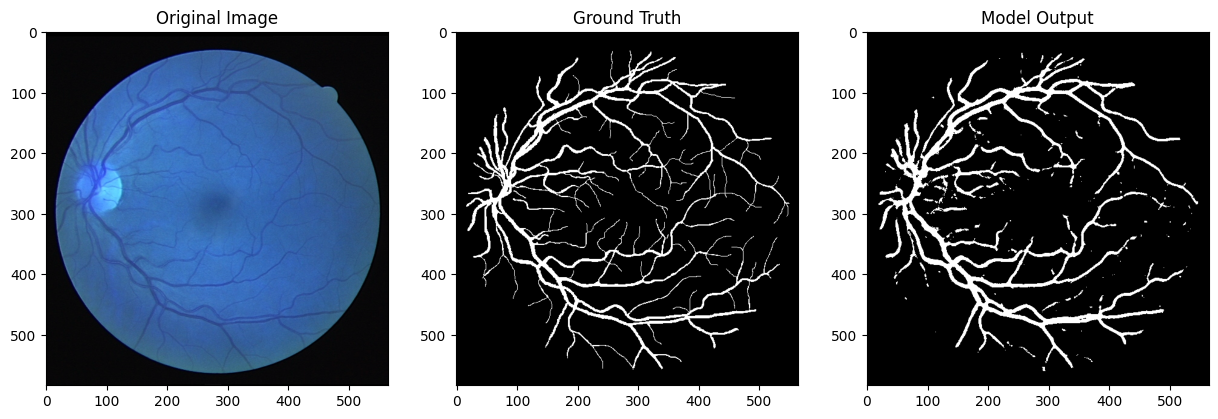

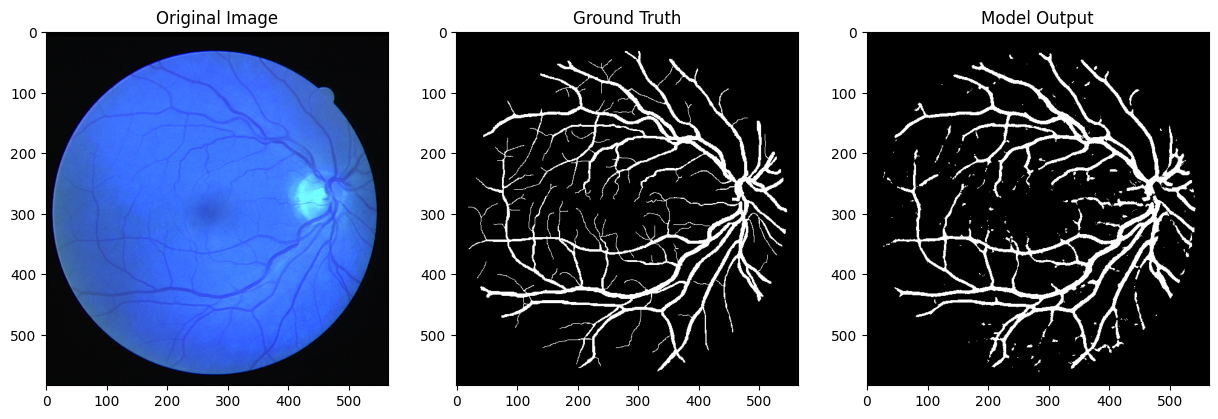

In [ ]:
import matplotlib.pyplot as plt

sample_indices = [0, 1]

sum = 0

for i in sample_indices:
    image = cv2.imread(join(test_image_path, images[i]))
    mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
    label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
    label[np.where(label == 255)] = 1
    index = np.where(mask != 0)
    cnt = index[0].shape[0]

    temp = np.zeros((584, 565))
    X = torch.from_numpy(X_test[sum:sum + cnt, :]).to(DEVICE)
    Y = Y_test[sum:sum + cnt]

    if X.shape[0] > 0:
        out = model(X.float()).reshape(Y.shape) >= 0.4

        x, y = index
        for idx in range(cnt,):
            m = x[idx]
            n = y[idx]

            if out[idx] == 1:
                temp[m, n] = 255

    sum += cnt

    border = LOG_Edge_Detection(mask)
    kernel = np.ones((4, 4), np.uint8)
    border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
    idx = np.where(border != 0)
    temp[idx] = 0

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(temp, cmap='gray')
    plt.title("Model Output")

    plt.show()